# Project 1: Wine Dataset Part 3

In this project, we aim to predict missing values for the 'residual sugar' column in the wine dataset. Since the original wine dataset does not contain any missing values in the 'residual sugar' column, we need to artificially introduce them. To create these missing values, we randomly select 10 rows where we set the 'residual sugar' to NaN. Subsequently, we build a regression model to predict these missing values. Finally, we evaluate the results obtained from the model.

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
import sklearn.metrics as skm
import scipy.stats as stats

In [34]:
# Source from where we imported the data
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"

# train dataframe should has no missing values for residual sugar
df_train = pd.read_csv(url, sep=';')
df_train.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [35]:
# Show some basic properties of the imported data
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [36]:
# remove rows with outliers
df_train = df_train[df_train['total sulfur dioxide']<200]

# zscore all columns
cols2zscore = df_train.keys()
df_train[cols2zscore] = df_train[cols2zscore].apply(stats.zscore)

# test dataframe should has missing values for residual sugar
df_test = df_train.copy()

In [37]:
# randomly pick some indices of the dataframe, where we want to replace the residual sugar by NaN
indices4removing = np.random.choice(df_test.index.values, 10)

# show the randomly picked indices
print(f'For the following row indices, we would like to replace the residual sugary by NaN: \n {indices4removing}\n')

# For controll, we check the number of NaN values before the replacement
numNanBefore = df_test['residual sugar'].isnull().sum()
print(f'Number of rows with missing values before: {numNanBefore}\n')

# set the residual sugar to be nan
df_test['residual sugar'].iloc[indices4removing] = np.nan

# For controll, we check the number of NaN values before the replacement
numNanAfter = df_test['residual sugar'].isnull().sum()
print(f'Number of rows with missing values after: {numNanAfter}')

# store the ground truth for residual sugar
ground_truth = df_test[df_test['residual sugar'].isnull()]

ground_truth

For the following row indices, we would like to replace the residual sugary by NaN: 
 [1416 1131  809 1205   63 1452   75 1220    0 1468]

Number of rows with missing values before: 0

Number of rows with missing values after: 10


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,-0.528350,0.960657,-1.391823,NaN,-0.244648,-0.464558,-0.382535,0.556807,1.288470,-0.580216,-0.959307,-0.786623
63,-0.758027,1.156260,-1.134520,NaN,-0.138404,-0.272903,0.246069,-0.080254,0.509584,-0.521212,-0.583341,-0.786623
75,0.275519,-0.660052,1.901661,NaN,0.116583,-0.656214,-0.131094,0.981515,1.483191,0.009828,0.074599,-0.786623
809,-0.413512,-0.268847,0.203458,NaN,-0.372141,-1.135354,-0.979709,0.094938,-0.593837,-0.639221,-0.113384,0.453492
1133,-0.643188,-0.268847,-1.031598,NaN,0.031587,-0.560386,-0.885418,0.047158,0.379770,0.127837,0.732539,1.693607
1207,0.907130,1.072430,1.438515,NaN,1.030284,0.781204,0.183208,0.408160,0.249955,1.661951,-0.395358,-0.786623
1222,-0.126416,0.010586,-0.259688,NaN,-0.202150,1.643656,1.346126,0.015305,-0.334209,-1.170260,-0.771324,0.453492
1418,-0.298673,0.010586,-1.340362,NaN,-0.223399,-1.231182,-0.853988,-0.929670,-0.983280,-1.170260,-0.583341,-0.786623
1454,1.940675,-0.436506,1.850200,NaN,-0.308395,-0.847870,-0.728267,1.586724,-0.658744,0.186841,0.450564,0.453492
1470,0.964549,0.904770,-0.825756,NaN,-0.074657,-0.752042,-0.696837,-0.515580,-2.800680,-1.111256,-0.677333,-0.786623


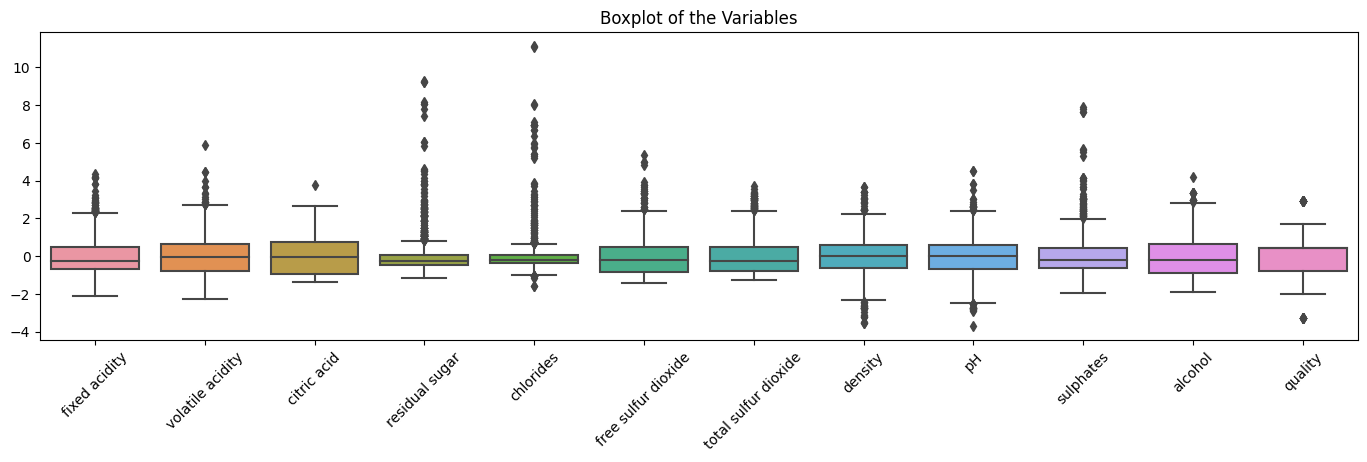

In [38]:
# Create a boxplot of all variables

fig, ax = plt.subplots(1,figsize=(17,4))
ax = sns.boxplot(data=df_test)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
ax.set_title('Boxplot of the Variables')
plt.show()

### Re-organize the data: train/test in DataLoaders

In [39]:
# Convert the data into Pytorch tensors
df_test.dropna(inplace=True)

# Covert the data and labels into pytorch tensors
dataT = torch.tensor(df_test.drop('residual sugar', axis=1).values).float()
labelT = torch.tensor(df_test['residual sugar'].values).float()
labelT = torch.reshape(labelT, (len(labelT), 1) )

# Covert the ground truth data and labels into pytorch tensors
gtDataT = torch.tensor(ground_truth.drop('residual sugar', axis=1).values).float()
gtLabelT = torch.tensor(df_train['residual sugar'].iloc[indices4removing].values).float()
gtLabelT = torch.reshape(gtLabelT, (len(gtLabelT), 1) )


# Convert the data into pytorch datasets
train_data = TensorDataset(dataT, labelT)
test_data = TensorDataset(gtDataT ,gtLabelT)

# Convert them into pytorch dataloader objects
batchsize = 128
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)

print(f'Original data: {df_test.shape}\n')
print(f'   Train data: {dataT.shape}\n')
print(f' Train labels: {labelT.shape}\n')
print(f'    Test data: {gtDataT.shape}\n')
print(f'  Test labels: {gtLabelT.shape}')

Original data: (1587, 12)

   Train data: torch.Size([1587, 11])

 Train labels: torch.Size([1587, 1])

    Test data: torch.Size([10, 11])

  Test labels: torch.Size([10, 1])


In [40]:
def creatTheModel():
    
    class WineNet(nn.Module):
        def __init__(self):
            super().__init__()
            
            ### input layer
            self.input = nn.Linear(11,16)
            
            ### hidden layer
            self.fc1 = nn.Linear(16,32)
            self.fc2 = nn.Linear(32,128)
            self.fc3 = nn.Linear(128,32)
            
            ### output layer
            self.output = nn.Linear(32,1)
            
        def forward(self,x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            x = F.relu(self.fc2(x))
            x = F.relu(self.fc3(x))
            return self.output(x)
    
    # create an instance of the model
    net = WineNet()
    
    
    # lossfunction
    lossfun = nn.MSELoss()
    
    # optimizer
    optimizer = torch.optim.Adam(net.parameters(), lr=0.01)
    
    return net, lossfun, optimizer           

In [41]:
def trainTheModel():
    
    # number of epochs
    numepochs = 400
    
    # create a model
    net, lossfun, optimizer = creatTheModel()
    
    # initialize losses
    losses = torch.zeros(numepochs)
    
    # loop over training epochs
    
    for epochi in range(numepochs):
        
        # loop obver batch
        batchLoss = []
        
        for X,y in train_loader:
            
            # forward pass
            yHat = net(X)
            loss = lossfun(yHat, y)
            
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            # compute loss
            batchLoss.append(loss.item())
        # end of batch loop...
        
        #get the avarage loss across the batches
        losses[epochi] = np.mean(batchLoss)
        
    return losses, net          

In [42]:
# get the losses and the trained net
losses, net = trainTheModel()

# predict the training values
yHatTrain = net(dataT).detach()

# predict the (missing) test values
yHatTest = net(gtDataT )

# convert the missing values into numpy arrays
yHatTest = yHatTest.detach().cpu().numpy().flatten()
gtLabelT = gtLabelT.detach().cpu().numpy().flatten()

# create a dataframe to compare the predicted misssing values with it's ground truth
display(pd.DataFrame.from_dict({'Ground Truth Value': gtLabelT , 'Predicted Value': yHatTest }))

# print the mean squared error for our predicted values
print(f'For our prediction we have a mean squared error of {skm.mean_squared_error(gtLabelT,yHatTest)}')

,Ground Truth Value,Predicted Value
0,-0.667550,-0.473647
1,2.127074,-0.126564
2,0.192334,-0.259741
3,-0.595893,0.392006
4,-0.380922,2.450072
5,-0.237608,-0.802863
6,-0.237608,0.103141
7,-0.237608,-0.713352
8,-0.452579,0.337271
9,-0.810864,-0.393285


For our prediction we have a mean squared error of 1.5771514177322388


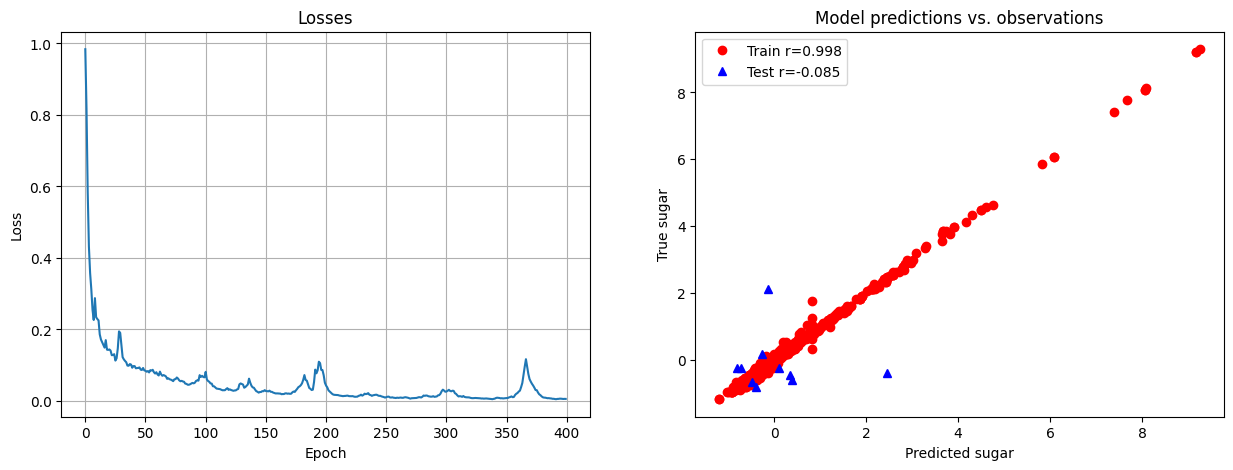

In [43]:
# plot some results

fig, ax = plt.subplots(1,2, figsize=(15,5))

# plot the losses
ax[0].plot(losses)
ax[0].set_title('Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].grid(True)

# plot prediction vs observations
ax[1].plot(yHatTrain, labelT.detach(), 'ro')
ax[1].plot(yHatTest, gtLabelT, 'b^')
ax[1].set_title('Model predictions vs. observations')
ax[1].set_xlabel('Predicted sugar')
ax[1].set_ylabel('True sugar')

# correlation between prediction and output
corrTrain = np.corrcoef(yHatTrain.T, labelT.detach().T)[1,0]
corrTest = np.corrcoef(yHatTest.T, gtLabelT.T)[1,0]
ax[1].legend([f'Train r={corrTrain:.3f}',f'Test r={corrTest:.3f}'])
plt.show()

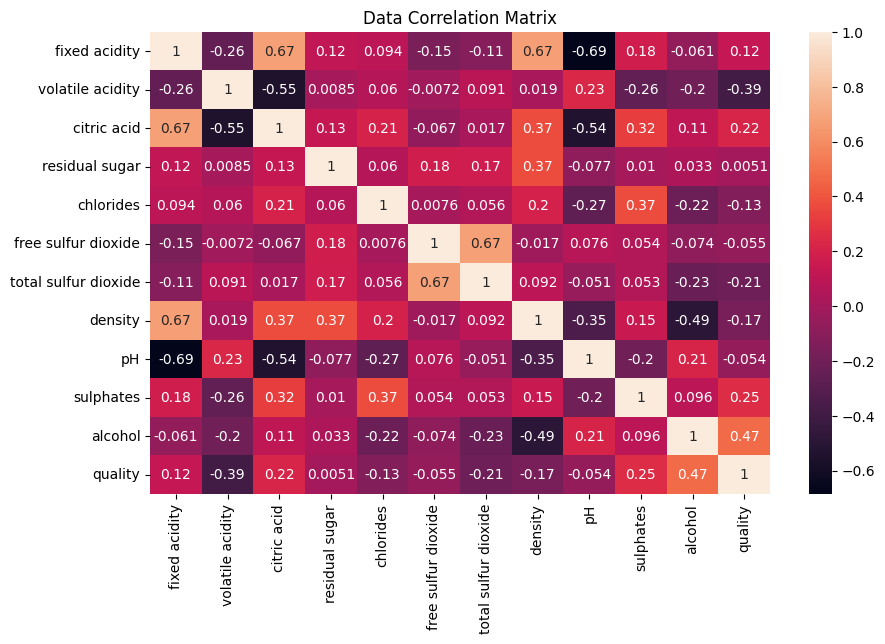

In [54]:
# Inspect the correlation matrix

plt.figure(figsize=(10,6))
sns.heatmap(df_train.corr(), annot=True)
plt.title('Data Correlation Matrix')
plt.show()